# Forecast Carbon Emission
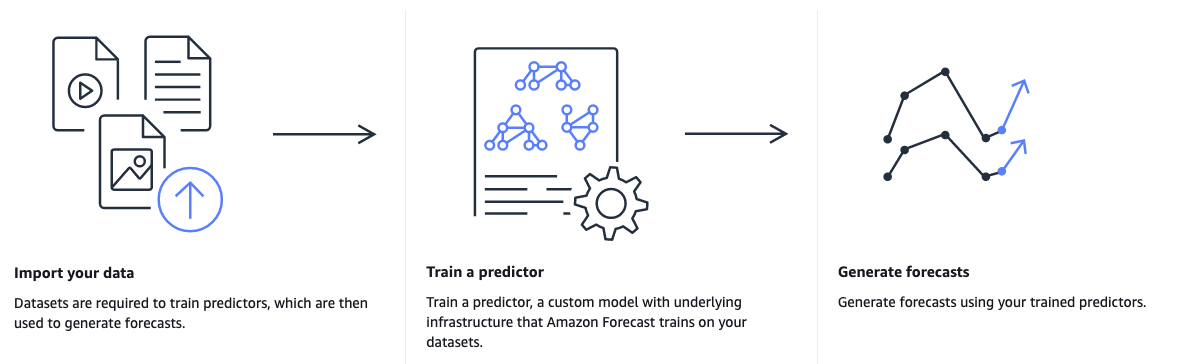


#### Amazon Forecast is a fully managed service that uses statistical and machine learning algorithms to deliver highly accurate time-series forecasts. It provides state-of-the-art algorithms to predict future time-series data based on historical data, and requires no machine learning experience. It also provides several filling methods to automatically handle missing values in your datasets 

#### This Notebook will show an example of how to learn from the historical CO2 equivalent data on the enriched data bucket to predict the calculated CO2 equivalent for the future months using Amazon Forecast  

#### Forecasting projects in Amazon Forecast has three main processes:
#### 1) Import your Datasets - Datasets are collections of your input data. Dataset groups are collections of datasets that contain complimentary information. Forecast algorithms use your dataset groups to train custom forecasting models, called predictors.
#### 2) Training Predictors - Predictors are custom models trained on your data. You can train a predictor by choosing a prebuilt algorithm,or by choosing the AutoML option to have Amazon Forecast pick the best algorithm for you.
#### 3) Generating Forecasts - You can generate forecasts for your time-series data, query them using the QueryForecast API, or visualize them in the console.

#### You also have an option to include related time series dataset & item metadata dataset while creating the Datasets. Related time series dataset is a complementary related time series dataset that isn't included in a target time series dataset and might improve the accuracy of your predictor (Eg: Weather). An item metadata dataset contains categorical data that provides valuable context for the items in a target time-series dataset (eg: brand, color, model). This is out-of-scope for this example


## Setup and prerequisites

In [ ]:
# install required libraries
# uncomment the line below if this is your first time running this notebook
# %pip install pandas s3fs matplotlib ipywidgets boto3 dask awswrangler

In [ ]:
import json
import boto3
import datetime
import pandas as pd
from time import sleep
import dateutil.parser
import awswrangler as wr
from random import choice
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [ ]:
# user defined constants
# ENRICHED_BUCKET_NAME is where the calculated CO2 emission equivalent data is stored. Data is stored in parquet file format. There may be multiple parquet files within this bucket depending on the emission inout data
# RESULTS_BUCKET_NAME is where you forecasted CO2 emission equivalent data is stored
# FORECAST_ROLE_ARN is the IAM Role used by Amazon Forecast to access your data
ENRICHED_BUCKET_NAME = '<YOUR_ENRICHED_BUCKET_NAME>' # You can find this in the cdk-outputs.json file under `CDLEnrichedDataBucket`
RESULTS_BUCKET_NAME = '<YOUR_FORECAST_RESULTS_BUCKET_NAME>' # You can find this in the cdk-outputs.json file under `CDLForecastResultsBucket`
FORECAST_ROLE_ARN = '<YOUR_FORECAST_ROLE_ARN>' # You can find this in the cdk-outputs.json file under `CDLForecastResultsRole`

In [ ]:
# aws constants
AWS_REGION = boto3.Session("s3").region_name
AWS_ACCOUNT = boto3.client('sts').get_caller_identity().get('Account')

S3_KEY_PREFIX = 'data' # what prefix to add to generated results in S3
S3_KEY_TRAINING = f"s3://{RESULTS_BUCKET_NAME}/training_data.csv"
S3_KEY_VALIDATION = f"s3://{RESULTS_BUCKET_NAME}/validation_data.csv"
DATE_FORMAT = '%Y-%m'
DATA_VERSION = 1
LOCAL_PATH = "./tts.csv"

# forecast constants
FORECAST_FREQ = "M" # What is your forecast time unit granularity? other options are M/H/D/W/Y
FORECAST_LENGTH = 12 # what is your forecast horizon in number time units you've selected? 
TIMESTAMP_FORMAT = "yyyy-MM-dd"

In [ ]:
# setup AWS clients
session = boto3.Session(region_name=AWS_REGION)
s3_client = session.client('s3')
forecast = session.client(service_name='forecast') 
forecast_query = session.client(service_name='forecastquery')

## Inspect the enriched data

### Load the raw data from Carbon Lake "Enriched" bucket and cleanup

In [ ]:
#read all the calculated CO2 emissions equivalent parquet files from the enriched s3 bucket
df = wr.s3.read_parquet(f"s3://{ENRICHED_BUCKET_NAME}")

In [ ]:
# change data types as needed
## extract the desired values from the emissions_output map
df['calculated_emissions_co2e'] = pd.to_numeric(df['emissions_output.calculated_emissions.co2.amount'],downcast='float')
df['origin_measurement_timestamp'] = pd.to_datetime(df["origin_measurement_timestamp"], format=DATE_FORMAT, errors='coerce')

In [ ]:
## Amazon Forecast expects the following fields - https://docs.aws.amazon.com/forecast/latest/dg/custom-domain.html
## A Timestamp, an Item ID and a target Value are the 3 key required pieces of information to generate a forecast with Amazon Forecast. More can be added but these 3 must always remain present.
## Map these values to your target dataset and filter these 3 columns for creating the Dataset
FORECAST_FIELDS = {
    "item_id": "asset_id",
    "timestamp": "origin_measurement_timestamp",
    "target_value": "calculated_emissions_co2e",
}

df_filtered = df.filter(list(FORECAST_FIELDS.values()))
df_filtered = df_filtered.rename(dict((v,k) for k,v in FORECAST_FIELDS.items()), axis='columns')

In [ ]:
# Since the calculated CO2 equivalent emissions are from a daily dataset and our forecasting frequncy is monthly, aggregate the daily data into monthly groups for monthly forecasting forecasting
agg_func_math = {
    'item_id': ['first'],
    'timestamp': ['first'],
    'target_value': ['sum']
}
df_monthly_aggregated = df_filtered.groupby(['item_id', 'timestamp'], as_index=False).agg(agg_func_math).round(2)

df_filtered = pd.DataFrame(data=df_monthly_aggregated)
df_filtered.columns = list(FORECAST_FIELDS.keys())
df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])

In [ ]:
print(df_filtered.head())

### Visualize historical emission of a sample assest

In [ ]:
## Pick a random asset and visulaize the historical emissions information
sample_asset = df_filtered.iloc[choice(df_filtered.index)]['item_id']
print(f"sample_asset = {sample_asset}")
sample_df = df_filtered[df_filtered['item_id'] == sample_asset]

plt.show()
plt.rc('font', size=16)
fig, ax = plt.subplots(figsize=(24, 6))

# Specify how our lines should look and setup your legends
ax.plot(sample_df.timestamp, sample_df.target_value, color='tab:blue', label=f'{sample_asset} emissions')
ax.set_xlabel('time')
ax.set_ylabel('Emissions')
ax.grid(True)
ax.legend(loc='upper left');


### Save a snapshot of a filtered data, training data, and validation data locally

In [ ]:
# save snapshot locally
sample_df.to_csv(LOCAL_PATH, header=False, index=False)
print(f"Saved sample data locally to {LOCAL_PATH}")

In [ ]:
end_time_train = df_filtered['timestamp'].max() - relativedelta(months=FORECAST_LENGTH)
snapshot_date = end_time_train.date() + relativedelta(months=1)
EXPERIMENT_NAME = f"co2_emission_forecast_snap_{snapshot_date.strftime('%m%Y')}_{FORECAST_LENGTH}_{FORECAST_FREQ}"

In [ ]:
# Save the local time series data to S3
key = f"{S3_KEY_PREFIX}/v{DATA_VERSION}/{EXPERIMENT_NAME}.csv"
s3_client.upload_file(LOCAL_PATH, RESULTS_BUCKET_NAME, key)
print(f"Uploaded TTS to s3://{RESULTS_BUCKET_NAME}/{key}")

In [ ]:
# We will now split the data into train_data and validation_data. The train_data will be used for training the predictor and the validation_data will be used to validate our forecast.
train_data = sample_df[sample_df['timestamp'] <= end_time_train]
validation_data = sample_df[sample_df['timestamp'] > end_time_train]

_ = wr.s3.to_csv(df=train_data, path=S3_KEY_TRAINING, header=False, index=False)
_ = wr.s3.to_csv(df=validation_data, path=S3_KEY_VALIDATION, header=False, index=False)

## Forecasting

### Importing the Dataset to Amazon Forecast

Next, we will create a Dataset and Import the calculated co2e from S3 to Amazon Forecast. To train a Predictor we will need a DatasetGroup that groups the input Datasets. So, we will end this step by creating a DatasetGroup with the imported Dataset.

In [ ]:
DATASET_NAME = 'co2_emission_aggregated_dataset'
DATASET_GROUP_NAME = 'co2_emission_dataset_group'
DATASET_IMPORT_JOB_NAME = 'DSIMPORT_JOB_TARGET'

# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
SCHEMA ={
   "Attributes":[
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      },
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      }
   ]
}

In [ ]:
create_dataset_response = forecast.create_dataset(
   Domain="CUSTOM",
   DatasetType='TARGET_TIME_SERIES',
   DatasetName=DATASET_NAME,
   DataFrequency=FORECAST_FREQ, 
   Schema = SCHEMA
)
dataset_arn = create_dataset_response['DatasetArn']

In [ ]:
# Create the DatasetGroup
create_dataset_group_response = forecast.create_dataset_group(
    DatasetGroupName=DATASET_GROUP_NAME,
    DatasetArns=[ dataset_arn ],
    Domain="CUSTOM"
)
dataset_group_arn = create_dataset_group_response['DatasetGroupArn']

In [ ]:
# Finally we can can import the dataset
ds_import_job_response = forecast.create_dataset_import_job(
    DatasetImportJobName=DATASET_IMPORT_JOB_NAME,
    DatasetArn=dataset_arn,
    DataSource= {
        "S3Config" : {
            "Path": S3_KEY_TRAINING,
            "RoleArn": FORECAST_ROLE_ARN
        } 
    },
    TimestampFormat=TIMESTAMP_FORMAT
)
ds_import_job_arn = ds_import_job_response['DatasetImportJobArn']

In [ ]:
# check status of the import job
import_status = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
print(f"Waiting for Import Job ({DATASET_IMPORT_JOB_NAME}) to become ACTIVE. Depending on data size, this can take several minutes.")
print(f'Current Status: {import_status}', end='\r')

# wait for import job to complete - this may take a while
while (import_status != 'ACTIVE' and import_status != 'CREATE_FAILED'):
    sleep(30)
    import_status = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(f'Current Status: {import_status}', end='\r')

### Train the predictor in Amazon Forecast

In [ ]:
PREDICTOR_NAME = "CO2_EMISSION_PREDICTOR"
FORECAST_NAME = "CO2_EMISSION_FORECAST"
FORECAST_HORIZON = 3
FORECAST_FREQUENCY = "M"

In [ ]:
create_auto_predictor_response = forecast.create_auto_predictor(
    PredictorName = PREDICTOR_NAME,
    ForecastHorizon = FORECAST_HORIZON,
    ForecastFrequency = FORECAST_FREQUENCY,
    DataConfig = {
        'DatasetGroupArn': dataset_group_arn
    },
    ExplainPredictor = True
)
predictor_arn = create_auto_predictor_response['PredictorArn']

In [ ]:
predictor_status = forecast.describe_auto_predictor(PredictorArn=predictor_arn)["Status"]
print(f"Waiting for Predictor ({PREDICTOR_NAME}) to become ACTIVE. Depending on data size and predictor setting, this can take several hours.\n")
print(f'Current Status: {predictor_status}', end='\r')

while (predictor_status != 'ACTIVE' and predictor_status != 'CREATE_FAILED'):
    sleep(30)
    predictor_status = forecast.describe_auto_predictor(PredictorArn=predictor_arn)["Status"]
    print(f'Current Status: {predictor_status}', end='\r')

## Analyse Accuracy Metrics

#### Types of accuracy metrics
##### Weighted Quantile Loss (wQL) metric measures the accuracy of a model at a specified quantile. It is particularly useful when there are different costs for underpredicting and overpredicting.

##### Root Mean Square Error (RMSE) uses the squared value of the residuals, which amplifies the impact of outliers. In use cases where only a few large mispredictions can be very costly, the RMSE is the more relevant metric.

##### Weighted Absolute Percentage Error (WAPE) is more robust to outliers than Root Mean Square Error (RMSE) because it uses the absolute error instead of the squared error.

##### Mean Absolute Percentage Error (MAPE) is useful for cases where values differ significantly between time points and outliers have a significant impact.

##### Mean Absolute Scaled Error (MASE) is ideal for datasets that are cyclical in nature or have seasonal properties.

In [ ]:
get_accuracy_metrics_response = forecast.get_accuracy_metrics(PredictorArn=predictor_arn)
wql = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['WeightedQuantileLosses']
accuracy_scores = get_accuracy_metrics_response['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['ErrorMetrics'][0]

print(f"Weighted Quantile Loss (wQL): {json.dumps(wql, indent=2)}")
print(f"Root Mean Square Error (RMSE): {accuracy_scores['RMSE']}")
print(f"Weighted Absolute Percentage Error (WAPE): {accuracy_scores['WAPE']}")
print(f"Mean Absolute Percentage Error (MAPE): {accuracy_scores['MAPE']}")
print(f"Mean Absolute Scaled Error (MASE): {accuracy_scores['MASE']}")

### Generate Forecast for next X months

In [ ]:
create_forecast_response = forecast.create_forecast(
    ForecastName=FORECAST_NAME,
    PredictorArn=predictor_arn
)
forecast_arn = create_forecast_response['ForecastArn']

In [ ]:
forecast_status = forecast.describe_forecast(ForecastArn=forecast_arn)["Status"]
print(f"Waiting for forecast ({FORECAST_NAME}) to become ACTIVE. This can take several hours.\n")
print(f'Current Status: {forecast_status}', end='\r')

while (forecast_status != 'ACTIVE' and forecast_status != 'CREATE_FAILED'):
    sleep(30)
    forecast_status = forecast.describe_forecast(ForecastArn=forecast_arn)["Status"]
    print(f'Current Status: {forecast_status}', end='\r')

### Query the forecasted results in the Amazon Forecast service console by selecting the corresponding Dataset Group

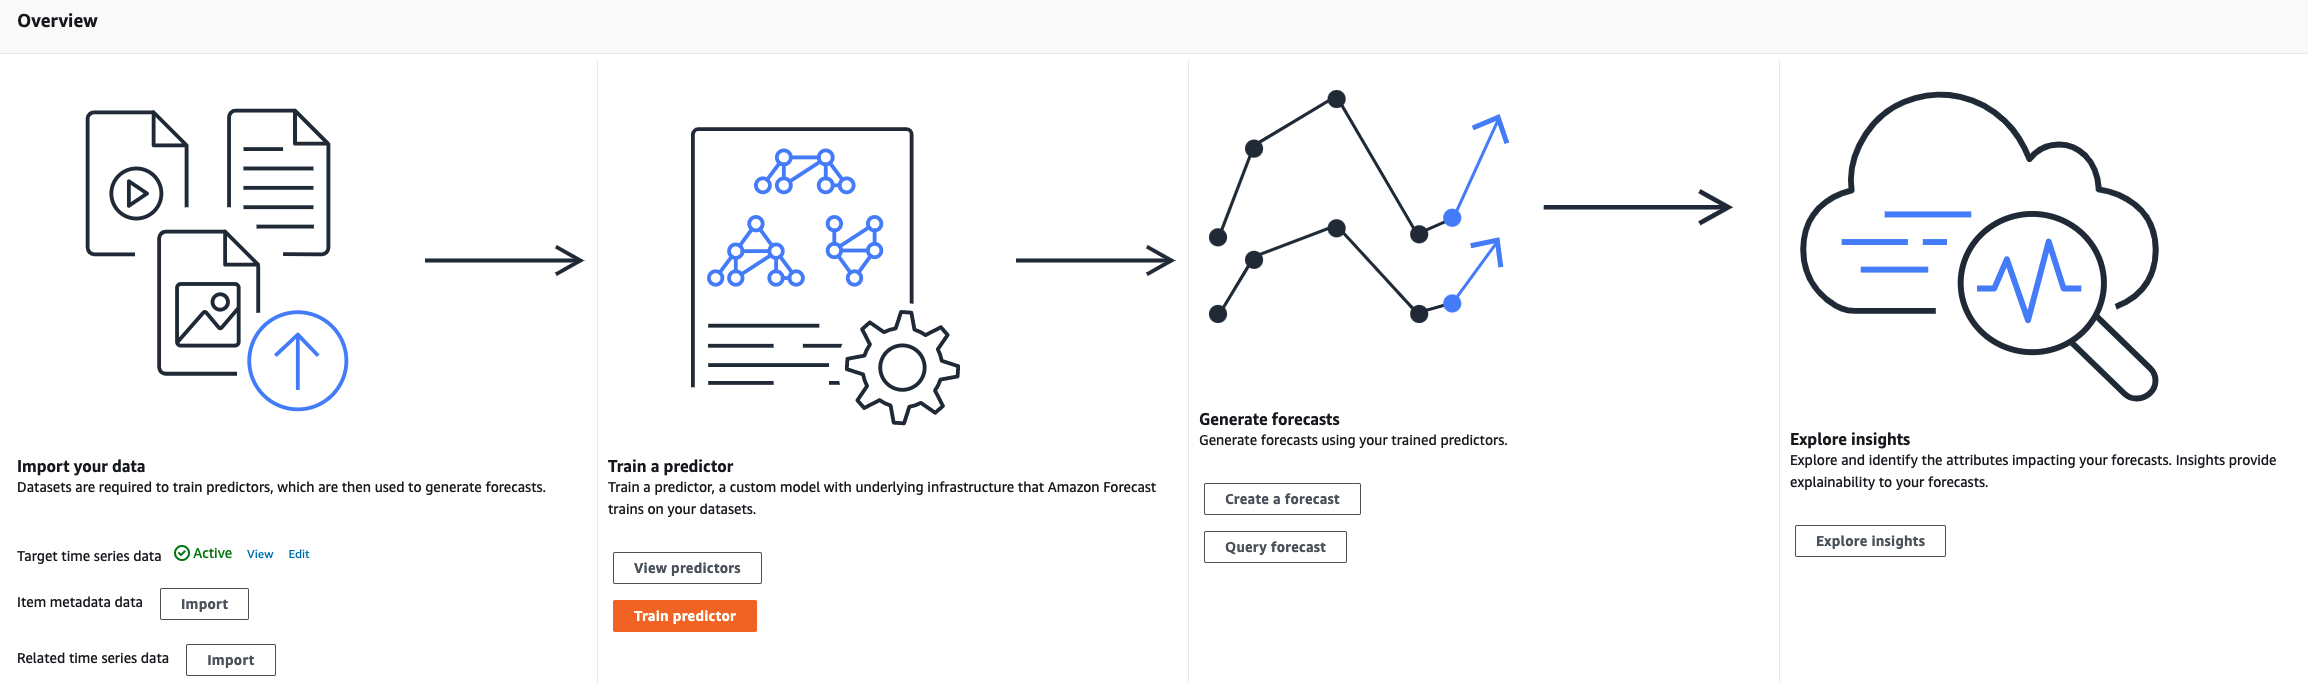

In [ ]:
FORECAST_QUERY_START = '2021-01-01T00:00:00'
FORECAST_QUERY_END = '2021-03-01T00:00:00'

In [ ]:
query_results = forecast_query.query_forecast(
    ForecastArn=forecast_arn,
    StartDate=FORECAST_QUERY_START,
    EndDate=FORECAST_QUERY_END,
    Filters={
        "item_id": "vehicle103"
    }
)["Forecast"]

In [ ]:
query_results